**Goal**: 

Determine if Hassan transform renders some (CT) texture of firstorder features independent of GL discretization which leads to a reduction of the feature space dimensionality.

[Hassan supplementary matreial](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-28895-9/MediaObjects/41598_2018_28895_MOESM1_ESM.pdf)


**Observations**:
* Applying Hassan transform to features calculated from images where damaged slices were removed reduced the ICC between features calculated from differently discretized images.
* Compared to features calculated from images where damaged slices were removed, applying Hassan transfrom to features calculated from the original images results in relaxed dependency between CT texture features and different image discretizations.
* May choose to proceed with Original Images data set due to this feature.
* It appears that the CT texture transformations also have an effect on PET features which further contributes to reduce the dimensionality of the feature space wihtou significant loss of information.

In [25]:
import os
import re
import nrrd

from ioutil import sample_paths

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sns.set()
%matplotlib inline

In [2]:
def column_regexes(X):
    
    col_regexes = []
    for col in X.columns:
        items = col.split('_')
        if 'bins' in items[-1]:
            col_regexes.append(('_').join(items[1:-1]))
        else:
            col_regexes.append(('_').join(items[1:]))

    return np.unique(col_regexes)

In [3]:
def prep_labels(labels, pref='CT'):
    
    new_labels = []
    for label in labels:

        items = label.split('_')

        if len(items) == 3:
            if items[1] == 'firstorder':
                kind = 'First Order'
            else:
                kind = items[1].upper()
                
            if len(items[2]) > 20:
                new_labels.append(f'{pref} {kind}\n{items[2]}')
            else:
                new_labels.append(f'{pref} {kind} {items[2]}')

        else:
            raise ValueError(f'Cannot handle label {label}')
    
    return new_labels

In [4]:
def to_feature_categories(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        if 'shape' in label:
            prep_labels.append('Shape')
        elif 'PETparam' in label:
            prep_labels.append('PET Parameter')
        elif 'firstorder' in label:
            prep_labels.append('First Order')
        elif 'glcm' in label:
            prep_labels.append('GLCM')
        elif 'gldm' in label:
            prep_labels.append('GLDM')
        elif 'glrlm' in label:
            prep_labels.append('GLRLM')
        elif 'glszm' in label:
            prep_labels.append('GLSZM')
        elif 'ngtdm' in label:
            prep_labels.append('NGTDM')
        else:
            prep_labels.append('Clinical')
    return prep_labels

In [5]:
# https://github.com/cosanlab/nltools/blob/master/nltools/data/brain_data.py
# https://www.aliquote.org/cours/2012_biomed/biblio/Shrout1979.pdf
def icc(Y):
    """Calculate intraclass correlation coefficient (ICC). 
    
    Reference: 
        Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
        assessing rater reliability. Psychological bulletin, 86(2), 420.
    
    Args:
        X (array-like): Data matrix with observations on rows
            and measurements on columns.

    Returns:
        (float): Intraclass correlation coefficient.
                
    """    
    n, k = np.shape(Y)
    
    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    Y_avg = np.mean(Y)
    SST = np.sum((Y - Y_avg) ** 2)

    # Create the design matrix for the different levels:
    # * Sessions:
    x = np.kron(np.eye(k), np.ones((n, 1)))  
    # * Subjects:
    x0 = np.tile(np.eye(n), (k, 1))
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(
        np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))), X.T), Y.flatten('F')
    )
    residuals = Y.flatten('F') - predicted_Y
    SSE = np.sum(residuals ** 2)

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = np.sum((np.mean(Y, axis=0) - Y_avg) ** 2) * n
    MSC = SSC / dfc / n

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    # ICC(3,1) = (mean square subject - mean square error) /
    # (mean square subject + (k-1)*mean square error)
    ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

NOTES: 
* Hassan found 17 features with trend varying according to GL discr. 
* Ng is the number of discrete gray levels in the image.
* Feature definitions implemented by Hassan et al. (2018) were compared to the feature definitions implemented in the PyRadiomics Python package.
----
* Identified PyRad features mathinch Hassan's (2018) study:
  * **GLCM**:
    * Entropy (named JointEntropy in PyRad)
    * Diff. entropy
    * Sum entropy 
    * Contrast     
    * Difference Variance (found! try out, but DIFFERENT seems to be formula in pyrad)
    * Sum Average
    * Difference Average (found! try out, but DIFFERENT seems to be formula in pyrad)
     (NOT found!)
  * **GLRLM**:
    * GLNU 
    * HGRE 
    * SRHGE 
  * **NGTDM**:
    * Contrast 
    * Complexity
    * Texture strength (named Strength in PyRad)
----
* Features from Hassan's study (2018) not found in PyRad:
  * **GLCM**:
    * Mean
    * Sum Variance (deprecated in PyRad)
    * Dissimilarity

In [6]:
# NOTE: Removed head `CT_` from regex.
hassan_transforms = {
    'original_glcm_DifferenceEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'original_glcm_JointEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'original_glcm_SumEntropy': lambda Ng, feature: feature * Ng,
    'original_glcm_Contrast': lambda Ng, feature: feature / (Ng ** 2),
    'original_glcm_DifferenceVariance': lambda Ng, feature: feature / (Ng ** 2),
    'original_glcm_SumAverage': lambda Ng, feature: feature / Ng,
    'original_glcm_DifferenceAverage': lambda Ng, feature: feature / Ng,
    'original_glrlm_GrayLevelNonUniformity': lambda Ng, feature: feature * Ng,
    'original_glrlm_HighGrayLevelRunEmphasis': lambda Ng, feature: feature / (Ng ** 2),
    'original_glrlm_ShortRunHighGrayLevelEmphasis': lambda Ng, feature: feature / (Ng ** 2),
    'original_ngtdm_Contrast': lambda Ng, feature: feature / Ng,
    'original_ngtdm_Complexity': lambda Ng, feature: feature / (Ng ** 3),
    'original_ngtdm_Strength': lambda Ng, feature: feature / (Ng ** 2),
}

In [7]:
def calc_icc(X, gl_bins):
    """Apply Hassan transform and record ICC for original and 
    transformed features.
    
    X (pandas.DataFrame):
    gl_bins (array-like):
    
    Returns:
        (pandas.DataFrame): 
    
    """
    icc_orig_feat = np.zeros(len(hassan_transforms.keys()))
    icc_norm_feat = np.zeros(len(hassan_transforms.keys()))
    for num, (key, transform) in enumerate(hassan_transforms.items()):

        feats = X.filter(regex=key)
       
        X_transf = np.zeros_like(feats)    
        for bin_num, (col, nbins) in enumerate(zip(feats.columns, gl_bins)):
            X_transf[:, bin_num] = transform(nbins, feats.loc[:, col].values)
    
        icc_orig_feat[num] = icc(feats.values)
        icc_norm_feat[num] = icc(X_transf)
        
    df_icc_orig_feat = pd.DataFrame(
        icc_orig_feat, index=hassan_transforms.keys(), columns=['Score']
    )
    df_icc_orig_feat['Kind'] = ['Original'] * len(hassan_transforms.keys())

    df_icc_norm_feat = pd.DataFrame(
        icc_norm_feat, index=hassan_transforms.keys(), columns=['Score']
    )
    df_icc_norm_feat['Kind'] = ['Modified'] * len(hassan_transforms.keys())
    df_icc = pd.concat((df_icc_orig_feat, df_icc_norm_feat), axis=0)
    
    df_icc.sort_values(by=['Score'])

    return df_icc

In [8]:
ICC_THRESH = 0.8

In [9]:
# Bin widths Z-scored CT stacks: Removed broken slices.
#width32 = 0.1303475935828877
#width64 = 0.06517379679144385
#width128 = 0.032586898395721924
#path_to_ct = './../../data_source/images/ct_removed_broken_slices/'
#path_to_ct_masks = './../../data_source/images/masks_removed_broken_slices_ct_size/'
#path_to_features= './../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv'
#path_hassan_icc_ct = './../../figures/compressing_feature_space/removed_broken_hassan_icc_ct_texture.png'
#path_hassan_icc_pet = './../../figures/compressing_feature_space/removed_broken_hassan_icc_pet_texture.png'
#path_hassan_icc_ct = './../../figures/compressing_feature_space/removed_broken_hassan_icc_ct_texture.png'
#path_hassan_icc_pet = './../../figures/compressing_feature_space/removed_broken_hassan_icc_pet_texture.png'
#path_to_icc = './../../data_source/to_analysis/compressed_features/all_features_removed_broken_icc.csv'
#path_scc_hassan_dropped =  './../../figures/compressing_feature_space/removed_broken_scc_hassan_dropped_radiom_feats.png'
#path_scc_hassan = './../../figures/compressing_feature_space/removed_broken_scc_hassan_radiom_feats.png'
#path_red_dropped = './../../data_source/to_analysis/compressed_features/all_features_removed_broken_icc_dropped.csv'
#path_pet_params_corr = './../../figures/compressing_feature_space/removed_broken_pet_params_corr.png',


# Bin widths Z-scored CT stacks: Original images.
width32 = 0.1351010101010101
width64 = 0.06755050505050506
width128 = 0.03377525252525253
path_to_ct = './../../data_source/images/ct_nrrd/'
path_to_ct_masks = './../../data_source/images/masks_nrrd/'
path_to_features = './../../data_source/to_analysis/original_images/all_features_original_images.csv'
path_hassan_icc_ct = './../../figures/compressing_feature_space/orig_images_hassan_icc_ct_texture.png'
path_hassan_icc_pet = './../../figures/compressing_feature_space/orig_images_hassan_icc_pet_texture.png'
path_to_icc = './../../data_source/to_analysis/compressed_features/all_features_orig_images_icc.csv'
path_scc_hassan_dropped =  './../../figures/compressing_feature_space/orig_images_scc_hassan_dropped_radiom_feats.png'
path_scc_hassan = './../../figures/compressing_feature_space/orig_images_scc_hassan_radiom_feats.png'
path_red_dropped = './../../data_source/to_analysis/compressed_features/all_features_orig_images_icc_dropped.csv'
path_pet_params_corr = './../../figures/compressing_feature_space/orig_images_pet_params_corr.png'


# Get number of GL

In [10]:
path_ct_stacks = sample_paths(path_to_ct, path_to_ct_masks, target_format='nrrd')

gl_32bins = np.zeros(len(path_ct_stacks))
gl_64bins = np.zeros(len(path_ct_stacks))
gl_128bins = np.zeros(len(path_ct_stacks))

idx = []
for num, ct_path in enumerate(path_ct_stacks):
    
    fname = os.path.basename(ct_path['Image'])
    idx_num = re.findall(r'\d+', fname.split('.')[0])[0]
    idx.append(int(idx_num))
    
    image, _ = nrrd.read(ct_path['Image'])
    mask, _ = nrrd.read(ct_path['Mask'])
    
    image = (image - np.mean(image)) / (np.std(image) + 1e-12)    

    cropped = image * mask
    data = cropped.ravel()
    
    # Binning operation as conducted in PyRadiomics.
    minimum = min(data)
    maximum = max(data)

    low_32_bound = minimum - (minimum % width32)
    low_64_bound = minimum - (minimum % width64)
    low_128_bound = minimum - (minimum % width128)

    high_32_bound = maximum + 2 * width32
    high_64_bound = maximum + 2 * width64
    high_128_bound = maximum + 2 * width128

    bin_32_edges = np.arange(low_32_bound, high_32_bound, width32)
    bin_64_edges = np.arange(low_64_bound, high_64_bound, width64)
    bin_128_edges = np.arange(low_128_bound, high_128_bound, width128)
    
    gl_32bins[num] = np.size(bin_32_edges)
    gl_64bins[num] = np.size(bin_64_edges)
    gl_128bins[num] = np.size(bin_128_edges)

In [11]:
gl_32bins.shape, gl_64bins.shape, gl_128bins.shape

((198,), (198,), (198,))

In [12]:
# The average number of bins per GL discretization for the CURRENT images.
np.mean(gl_32bins), np.mean(gl_64bins), np.mean(gl_128bins)

(27.63131313131313, 52.24242424242424, 101.44949494949495)

In [13]:
np.median(gl_32bins), np.median(gl_64bins), np.median(gl_128bins)

(27.0, 50.5, 98.0)

In [14]:
np.std(gl_32bins), np.std(gl_64bins), np.std(gl_128bins)

(8.332147145452002, 16.59566141982393, 33.21334426279084)

In [15]:
np.min(gl_32bins), np.min(gl_64bins), np.min(gl_128bins)

(9.0, 16.0, 28.0)

In [16]:
np.max(gl_32bins), np.max(gl_64bins), np.max(gl_128bins)

(58.0, 112.0, 221.0)

# Data Prep

In [17]:
X = pd.read_csv(path_to_features, index_col=0)
X.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,47916.617451,0.094457,0.178525,0.358043,6.057050,25.566977,101.349019,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,19579.702532,0.070352,0.125185,0.238295,6.021110,27.043416,112.933552,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,14251.207526,0.054852,0.099392,0.191019,2.465487,10.711840,44.417785,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,7766.277251,0.024052,0.038650,0.070961,0.557200,2.723527,11.765552,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,2229.551107,0.029594,0.044499,0.082635,0.583427,3.013379,12.730022,7.213190,6.041,32.103770


In [18]:
clinical_features = pd.read_csv('./../../data_source/to_analysis/clinical_params.csv', index_col=0)
pet_params = pd.read_csv('./../../data_source/to_analysis/pet_params.csv', index_col=0)

shape_features = X.filter(regex='shape')
    
clinical_features = clinical_features.loc[X.index, :]
pet_params = pet_params.loc[X.index, :]

shape_features.shape, clinical_features.shape, pet_params.shape

((198, 14), (198, 42), (198, 3))

In [19]:
CT_feats = X.filter(regex='CT')
PET_feats = X.filter(regex='PET')

CT_feats.shape, PET_feats.shape

((198, 229), (198, 228))

In [20]:
CT_fo = CT_feats.filter(regex='firstorder')
CT_fo.head()

,CT_original_firstorder_10Percentile,CT_original_firstorder_90Percentile,CT_original_firstorder_Energy_32bins,CT_original_firstorder_Energy_64bins,CT_original_firstorder_Energy_128bins,CT_original_firstorder_Entropy_32bins,CT_original_firstorder_Entropy_64bins,CT_original_firstorder_Entropy_128bins,CT_original_firstorder_InterquartileRange,CT_original_firstorder_Kurtosis,...,CT_original_firstorder_RobustMeanAbsoluteDeviation,CT_original_firstorder_RootMeanSquared,CT_original_firstorder_Skewness,CT_original_firstorder_TotalEnergy_32bins,CT_original_firstorder_TotalEnergy_64bins,CT_original_firstorder_TotalEnergy_128bins,CT_original_firstorder_Uniformity_32bins,CT_original_firstorder_Uniformity_64bins,CT_original_firstorder_Uniformity_128bins,CT_original_firstorder_Variance
2,1064.381323,1115.994507,2.027206e+10,2.027206e+10,2.027206e+10,1.468230,2.332951,3.284691,23.619593,59.779383,...,10.146366,1087.472187,-5.516967,2.027206e+10,2.027206e+10,2.027206e+10,0.507842,0.284890,0.148104,1799.575765
4,972.027466,1183.041657,1.149213e+10,1.149213e+10,1.149213e+10,3.037896,4.005000,4.991176,79.044404,8.933352,...,35.567018,1090.659746,-1.626177,1.149213e+10,1.149213e+10,1.149213e+10,0.177185,0.093041,0.047069,9738.013189
5,1030.239139,1177.917830,1.989521e+10,1.989521e+10,1.989521e+10,2.628087,3.563321,4.542154,45.224022,14.831983,...,21.813694,1107.717919,-1.323719,1.989521e+10,1.989521e+10,1.989521e+10,0.256278,0.138937,0.071299,6755.913681
8,1028.577020,1085.938888,7.735412e+10,7.735412e+10,7.735412e+10,1.672882,2.350087,3.262609,22.494850,55.850257,...,10.195309,1056.102253,-6.427764,7.735412e+10,7.735412e+10,7.735412e+10,0.438593,0.301721,0.166060,5641.863881
10,1054.821012,1099.248341,1.240511e+10,1.240511e+10,1.240511e+10,1.411506,2.072728,2.999003,17.745937,46.402736,...,7.829789,1074.276985,-5.728072,1.240511e+10,1.240511e+10,1.240511e+10,0.527358,0.383870,0.199601,3393.119546


In [21]:
PET_fo = PET_feats.filter(regex='firstorder')
PET_fo.head()

,PET_original_firstorder_10Percentile,PET_original_firstorder_90Percentile,PET_original_firstorder_Energy,PET_original_firstorder_Entropy_32bins,PET_original_firstorder_Entropy_64bins,PET_original_firstorder_Entropy_128bins,PET_original_firstorder_InterquartileRange,PET_original_firstorder_Kurtosis,PET_original_firstorder_Maximum,PET_original_firstorder_MeanAbsoluteDeviation,...,PET_original_firstorder_Minimum,PET_original_firstorder_Range,PET_original_firstorder_RobustMeanAbsoluteDeviation,PET_original_firstorder_RootMeanSquared,PET_original_firstorder_Skewness,PET_original_firstorder_TotalEnergy,PET_original_firstorder_Uniformity_32bins,PET_original_firstorder_Uniformity_64bins,PET_original_firstorder_Uniformity_128bins,PET_original_firstorder_Variance
2,3.077370,20.253882,2.561311e+06,5.659824,6.654976,7.649966,11.377517,1.840003,24.741200,5.599564,...,1.204310,23.536890,4.557986,12.223637,0.417061,2.561311e+06,0.021880,0.010986,0.005520,40.888750
4,2.359130,14.203353,6.414469e+05,4.926591,5.911641,6.903339,7.077391,2.492294,18.655424,3.869878,...,1.433140,17.222283,2.971142,8.148343,0.854620,6.414469e+05,0.046026,0.023322,0.011727,20.679742
5,2.561257,12.976912,1.150483e+06,5.120955,6.116534,7.110672,6.511572,1.974056,16.739500,3.311875,...,1.163221,15.576279,2.608982,8.423547,0.269824,1.150483e+06,0.030189,0.015142,0.007612,14.867608
8,1.759327,8.697388,2.087304e+06,4.514368,5.506017,6.503110,4.139275,2.486921,14.210913,2.204753,...,0.743620,13.467292,1.678665,5.486017,0.616056,2.087304e+06,0.049555,0.025027,0.012545,6.898970
10,2.186233,6.536912,2.144240e+05,3.981418,4.973392,5.965635,2.451754,2.499014,8.792835,1.369596,...,0.982504,7.810330,1.009663,4.466349,0.484758,2.144240e+05,0.070593,0.035478,0.017818,2.722132


In [22]:
CT_text = CT_feats.drop(CT_fo.columns, axis=1)
CT_text.head()

,CT_original_glcm_Autocorrelation_32bins,CT_original_glcm_Autocorrelation_64bins,CT_original_glcm_Autocorrelation_128bins,CT_original_glcm_ClusterProminence_32bins,CT_original_glcm_ClusterProminence_64bins,CT_original_glcm_ClusterProminence_128bins,CT_original_glcm_ClusterShade_32bins,CT_original_glcm_ClusterShade_64bins,CT_original_glcm_ClusterShade_128bins,CT_original_glcm_ClusterTendency_32bins,...,CT_original_ngtdm_Coarseness_128bins,CT_original_ngtdm_Complexity_32bins,CT_original_ngtdm_Complexity_64bins,CT_original_ngtdm_Complexity_128bins,CT_original_ngtdm_Contrast_32bins,CT_original_ngtdm_Contrast_64bins,CT_original_ngtdm_Contrast_128bins,CT_original_ngtdm_Strength_32bins,CT_original_ngtdm_Strength_64bins,CT_original_ngtdm_Strength_128bins
2,188.467177,666.959960,2514.355159,106.428779,1604.042436,2.553674e+04,-8.218474,-59.836536,-475.671021,1.606197,...,0.000623,55.878031,303.202197,1483.543003,0.000985,0.001499,0.003685,0.378319,1.664586,5.107201
4,175.924167,677.683711,2659.050688,582.782391,9222.021011,1.465802e+05,-33.418179,-270.597971,-2155.486265,9.250200,...,0.001766,74.114881,405.528975,2831.107552,0.007444,0.013807,0.026754,0.391413,1.511447,5.988989
5,299.235958,1098.583708,4197.589181,544.123267,8664.015914,1.381295e+05,-13.276917,-114.133059,-909.124306,7.363435,...,0.000940,141.011011,732.720343,4275.509845,0.002250,0.004775,0.010649,0.717967,2.456720,8.195742
8,498.337533,1940.115687,7669.525915,4553.472658,71419.562276,1.139466e+06,-172.369072,-1358.885131,-10848.018631,9.248525,...,0.000145,184.917272,1109.753422,7532.649963,0.001900,0.002838,0.005608,0.324435,1.640934,7.026041
10,188.084026,711.807693,2794.027118,330.526467,4837.375450,7.730340e+04,-24.191289,-176.729052,-1412.020361,2.721015,...,0.000748,49.334280,330.922641,2304.032393,0.002149,0.003524,0.007783,0.558847,2.435301,8.870626


In [23]:
PET_text = PET_feats.drop(PET_fo.columns, axis=1)
# Skip PET parameter features.
pet_param_cols = [col for col in PET_text.columns if 'PETparam' in col]
PET_text.drop(pet_param_cols, axis=1, inplace=True)
PET_text.head()

,PET_original_glcm_Autocorrelation_32bins,PET_original_glcm_Autocorrelation_64bins,PET_original_glcm_Autocorrelation_128bins,PET_original_glcm_ClusterProminence_32bins,PET_original_glcm_ClusterProminence_64bins,PET_original_glcm_ClusterProminence_128bins,PET_original_glcm_ClusterShade_32bins,PET_original_glcm_ClusterShade_64bins,PET_original_glcm_ClusterShade_128bins,PET_original_glcm_ClusterTendency_32bins,...,PET_original_ngtdm_Coarseness_128bins,PET_original_ngtdm_Complexity_32bins,PET_original_ngtdm_Complexity_64bins,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins
2,881.930187,3378.433799,13220.049500,1.699027e+06,2.720392e+07,4.350874e+08,10159.472493,81419.103787,651041.441930,975.098948,...,0.004674,864.384257,6318.958179,47916.617451,0.094457,0.178525,0.358043,6.057050,25.566977,101.349019
4,342.024932,1281.855721,5072.035295,6.175762e+05,9.849732e+06,1.575009e+08,9115.133308,72756.345213,581748.258665,512.319472,...,0.007395,393.042044,2598.482766,19579.702532,0.070352,0.125185,0.238295,6.021110,27.043416,112.933552
5,397.555370,1487.008550,5746.841164,2.447537e+05,3.910213e+06,6.250897e+07,1342.640804,10734.291083,85739.927816,354.332919,...,0.005148,289.472152,1888.555090,14251.207526,0.054852,0.099392,0.191019,2.465487,10.711840,44.417785
8,179.723544,650.439057,2471.884833,6.698129e+04,1.068405e+06,1.708514e+07,1163.497389,9306.092822,74432.884302,167.510622,...,0.001351,198.656803,1132.255255,7766.277251,0.024052,0.038650,0.070961,0.557200,2.723527,11.765552
10,99.063149,378.728700,1410.354712,1.014657e+04,1.616099e+05,2.580295e+06,207.485212,1673.713276,13431.310582,64.815615,...,0.005649,53.301320,331.659405,2229.551107,0.029594,0.044499,0.082635,0.583427,3.013379,12.730022


# ICC & Hassan Transform of CT Texture Features

In [24]:
# Apply Hassan transform and record which features are transformed.
gl_bins = [gl_32bins, gl_64bins, gl_128bins]
df_ct_icc = calc_icc(CT_text, gl_bins)
df_ct_icc.head()

,Score,Kind
original_glcm_DifferenceEntropy,0.949614,Original
original_glcm_JointEntropy,0.958470,Original
original_glcm_SumEntropy,0.963446,Original
original_glcm_Contrast,0.308082,Original
original_glcm_DifferenceVariance,0.308401,Original


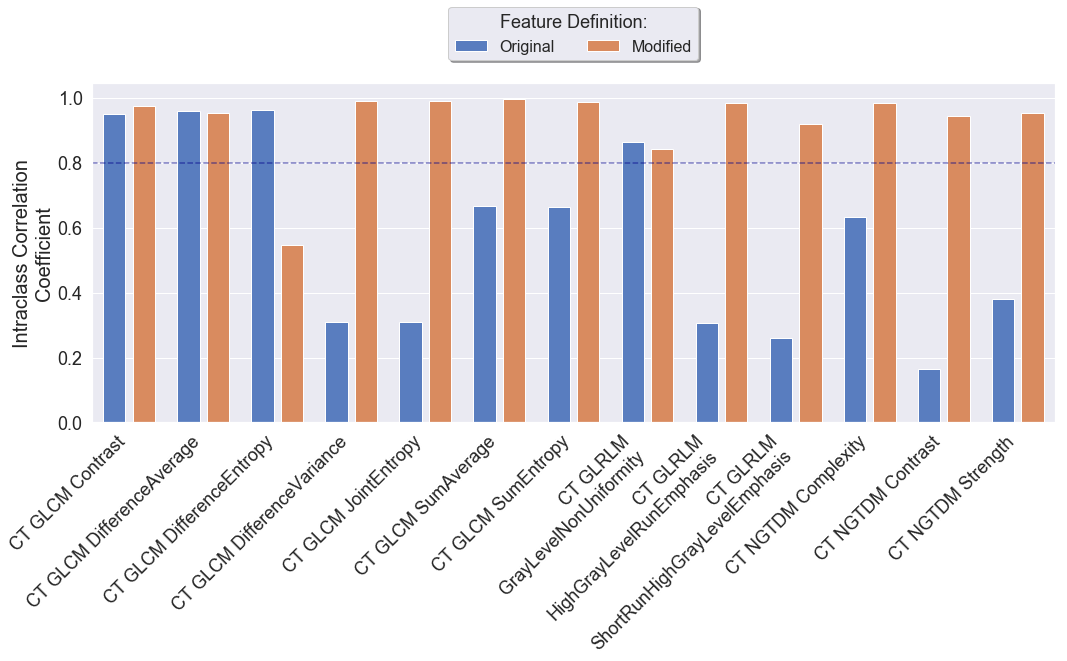

In [25]:
# Plotting original and transformed CT texture features.
plt.figure(figsize=(15, 10))
fig = sns.barplot(
    x=df_ct_icc.index, 
    y='Score', 
    hue='Kind', 
    data=df_ct_icc, 
    palette='muted',
)
plt.ylabel('Intraclass Correlation\nCoefficient', fontsize='20')
# Produces two sets of each label: one set for original, and one set for transformed 
# features.
labels = np.unique(prep_labels(hassan_transforms.keys()))
plt.xticks(
    np.arange(len(labels)), labels,
    rotation=45, ha='right', fontsize=18
)
plt.yticks(fontsize=18)

for patch_num, patch in enumerate(fig.patches):
    current_width = patch.get_width()
    diff = current_width - 0.3
    patch.set_width(0.3)
    # Recenter bars.
    patch.set_x(patch.get_x() + diff * 0.5)

plt.axhline(y=ICC_THRESH, linestyle='--', alpha=0.5, color='darkblue')
plt.legend(
    fontsize=16,
    title='Feature Definition:', title_fontsize=18,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.25),
    ncol=2, 
    fancybox=True, 
    shadow=True
)
plt.tight_layout()
plt.savefig(path_hassan_icc_ct)

# ICC & Hassan Transform PET Texture Features

In [26]:
gl_bins = [gl_32bins, gl_64bins, gl_128bins]
df_pet_icc = calc_icc(PET_text, gl_bins)

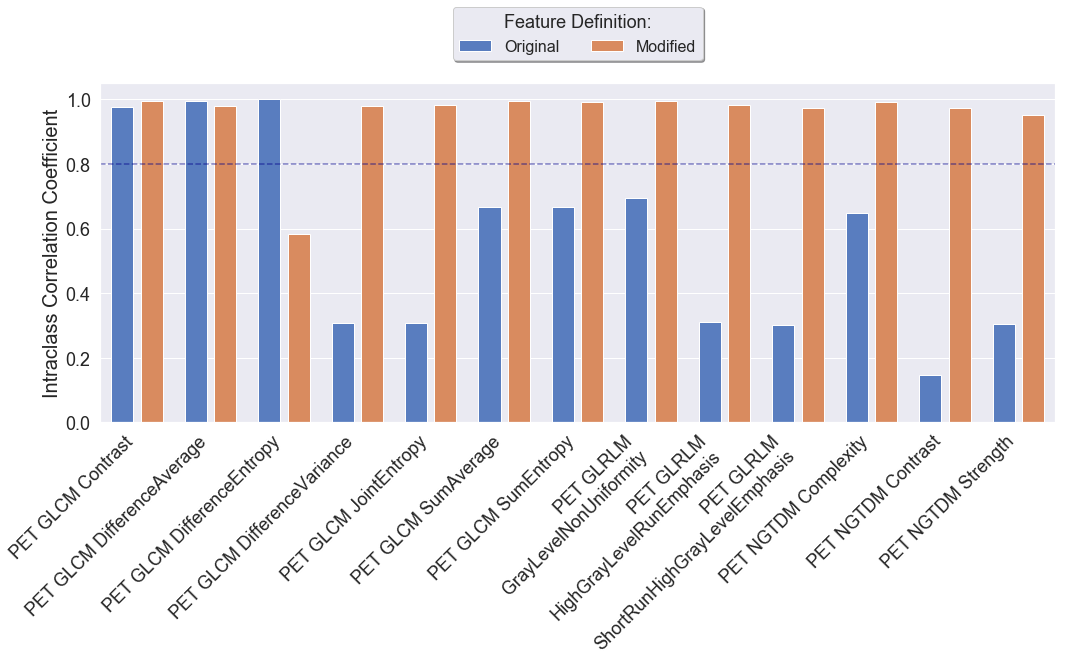

In [27]:
# Plotting original and transformed CT texture features.
plt.figure(figsize=(15, 10))
fig = sns.barplot(
    x=df_pet_icc.index, 
    y='Score', 
    hue='Kind', 
    data=df_pet_icc, 
    palette='muted',
)
plt.ylabel('Intraclass Correlation Coefficient', fontsize='20')
# Produces two sets of each label: one set for original, and one set for transformed 
# featuresm.
labels = np.unique(prep_labels(hassan_transforms.keys(), pref='PET'))
plt.xticks(
    np.arange(len(labels)), labels,
    rotation=45, ha='right', fontsize=18
)
plt.yticks(fontsize=18)

for patch_num, patch in enumerate(fig.patches):
    current_width = patch.get_width()
    diff = current_width - 0.3
    patch.set_width(0.3)
    # Recenter bars.
    patch.set_x(patch.get_x() + diff * 0.5)

plt.axhline(y=ICC_THRESH, linestyle='--', alpha=0.5, color='darkblue')
plt.legend(
    fontsize=16,
    title='Feature Definition:', title_fontsize=18,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.25),
    ncol=2, 
    fancybox=True, 
    shadow=True
)
plt.tight_layout()
plt.savefig(path_hassan_icc_pet)

# Remove Redundancy in PET and CT texture features

In [28]:
def hassan_to_feat_space(X, to_transf, gl_bins, prefix):
    
    # Modified only the spcified features. Other features 
    # are retained in original version.
    X_red = X.copy()
    for cols_to_transf in to_transf:

        feats = X.filter(regex=cols_to_transf)
        tmp_feats = np.zeros_like(feats) 
        transform = hassan_transforms[cols_to_transf]
        
        for bin_num, (col, nbins) in enumerate(zip(feats.columns, gl_bins)):
            tmp_feats[:, bin_num] = transform(nbins, feats.loc[:, col].values)
            
        if icc(feats.values) < icc(tmp_feats):
            new_feat = np.mean(tmp_feats, axis=1)
            X_red.loc[:, f'{prefix}_{cols_to_transf}'] = new_feat
            X_red.drop(feats.columns, axis=1, inplace=True)
        else:
            print(f'Not transforming {cols_to_transf}')
        
    return X_red

In [29]:
ct_transf_scores = df_ct_icc.loc[df_ct_icc.loc[:, 'Kind'] == 'Modified', 'Score']
ct_to_modify = (ct_transf_scores > ICC_THRESH).index.values

# Apply Hassan transform to features with ICC exceeding thresh. Drop redundant features.
CT_text_red = hassan_to_feat_space(CT_text, ct_to_modify, gl_bins, prefix='CT')
CT_text_red.head()

Not transforming original_glcm_JointEntropy
Not transforming original_glcm_SumEntropy
Not transforming original_glrlm_GrayLevelNonUniformity


,CT_original_glcm_Autocorrelation_32bins,CT_original_glcm_Autocorrelation_64bins,CT_original_glcm_Autocorrelation_128bins,CT_original_glcm_ClusterProminence_32bins,CT_original_glcm_ClusterProminence_64bins,CT_original_glcm_ClusterProminence_128bins,CT_original_glcm_ClusterShade_32bins,CT_original_glcm_ClusterShade_64bins,CT_original_glcm_ClusterShade_128bins,CT_original_glcm_ClusterTendency_32bins,...,CT_original_glcm_DifferenceEntropy,CT_original_glcm_Contrast,CT_original_glcm_DifferenceVariance,CT_original_glcm_SumAverage,CT_original_glcm_DifferenceAverage,CT_original_glrlm_HighGrayLevelRunEmphasis,CT_original_glrlm_ShortRunHighGrayLevelEmphasis,CT_original_ngtdm_Contrast,CT_original_ngtdm_Complexity,CT_original_ngtdm_Strength
2,188.467177,666.959960,2514.355159,106.428779,1604.042436,2.553674e+04,-8.218474,-59.836536,-475.671021,1.606197,...,0.177872,0.000913,0.000739,1.263559,0.013028,0.390803,0.229699,0.000043,0.004258,0.000870
4,175.924167,677.683711,2659.050688,582.782391,9222.021011,1.465802e+05,-33.418179,-270.597971,-2155.486265,9.250200,...,0.291466,0.002930,0.001865,1.316711,0.032114,0.428206,0.324919,0.000355,0.007183,0.000982
5,299.235958,1098.583708,4197.589181,544.123267,8664.015914,1.381295e+05,-13.276917,-114.133059,-909.124306,7.363435,...,0.243271,0.001087,0.000747,1.122216,0.018109,0.315332,0.228650,0.000082,0.003729,0.000694
8,498.337533,1940.115687,7669.525915,4553.472658,71419.562276,1.139466e+06,-172.369072,-1358.885131,-10848.018631,9.248525,...,0.194423,0.001082,0.000921,1.329104,0.012496,0.428311,0.263180,0.000047,0.003998,0.000358
10,188.084026,711.807693,2794.027118,330.526467,4837.375450,7.730340e+04,-24.191289,-176.729052,-1412.020361,2.721015,...,0.189610,0.001892,0.001643,1.353456,0.015516,0.433978,0.261114,0.000098,0.005385,0.001468


In [30]:
pet_transf_scores = df_pet_icc.loc[df_pet_icc.loc[:, 'Kind'] == 'Modified', 'Score']
pet_to_modify = (pet_transf_scores > ICC_THRESH).index.values

# Apply Hassan transform to features with ICC exceeding thresh. Drop redundant features.
PET_text_red = hassan_to_feat_space(PET_text, pet_to_modify, gl_bins, prefix='PET')
PET_text_red.head()

Not transforming original_glcm_JointEntropy
Not transforming original_glcm_SumEntropy


,PET_original_glcm_Autocorrelation_32bins,PET_original_glcm_Autocorrelation_64bins,PET_original_glcm_Autocorrelation_128bins,PET_original_glcm_ClusterProminence_32bins,PET_original_glcm_ClusterProminence_64bins,PET_original_glcm_ClusterProminence_128bins,PET_original_glcm_ClusterShade_32bins,PET_original_glcm_ClusterShade_64bins,PET_original_glcm_ClusterShade_128bins,PET_original_glcm_ClusterTendency_32bins,...,PET_original_glcm_Contrast,PET_original_glcm_DifferenceVariance,PET_original_glcm_SumAverage,PET_original_glcm_DifferenceAverage,PET_original_glrlm_GrayLevelNonUniformity,PET_original_glrlm_HighGrayLevelRunEmphasis,PET_original_glrlm_ShortRunHighGrayLevelEmphasis,PET_original_ngtdm_Contrast,PET_original_ngtdm_Complexity,PET_original_ngtdm_Strength
2,881.930187,3378.433799,13220.049500,1.699027e+06,2.720392e+07,4.350874e+08,10159.472493,81419.103787,651041.441930,975.098948,...,0.028412,0.011631,2.393262,0.126700,0.443418,1.917650,1.824347,0.004413,0.091278,0.014794
4,342.024932,1281.855721,5072.035295,6.175762e+05,9.849732e+06,1.575009e+08,9115.133308,72756.345213,581748.258665,512.319472,...,0.018857,0.008816,1.434235,0.096774,0.769841,0.876074,0.834363,0.003246,0.044219,0.017170
5,397.555370,1487.008550,5746.841164,2.447537e+05,3.910213e+06,6.250897e+07,1342.640804,10734.291083,85739.927816,354.332919,...,0.005499,0.001928,1.145509,0.058234,0.908452,0.408780,0.381790,0.001710,0.009510,0.003020
8,179.723544,650.439057,2471.884833,6.698129e+04,1.068405e+06,1.708514e+07,1163.497389,9306.092822,74432.884302,167.510622,...,0.001979,0.000872,0.671438,0.032432,1.582192,0.152450,0.137478,0.000613,0.004176,0.000601
10,99.063149,378.728700,1410.354712,1.014657e+04,1.616099e+05,2.580295e+06,207.485212,1673.713276,13431.310582,64.815615,...,0.003492,0.001371,0.891506,0.044876,1.417296,0.229068,0.202205,0.001213,0.005475,0.001836


# ICC of Remaining PET & CT Texture & First Order Features

The ICC may be used in further reduction of the feature space by calculating the ICC of each unique feature across image value discretizations, and remove those features with high correlations.

In [31]:
def combine_correlated_features(X, corr, prefix):
    
    X_red = X.copy()
    for col in corr:
        feats = X.filter(regex=col)
        X_red.loc[:, f'{prefix}_{col}'] = np.mean(feats, axis=1)
        X_red.drop(feats.columns, axis=1, inplace=True)
        
    return X_red

In [32]:
ct_fo_col_regexes = column_regexes(CT_fo)

ct_fo_icc = []
for ct_fo_regex in ct_fo_col_regexes:
    feats = CT_fo.filter(regex=ct_fo_regex)
    if len(feats.columns) == 3:
        ct_fo_icc.append(icc(feats.values))
    else:
        ct_fo_icc.append(0.0)
        
ct_fo_icc = np.array(ct_fo_icc)
ct_fo_to_mod = ct_fo_col_regexes[ct_fo_icc > ICC_THRESH]
CT_fo_red = combine_correlated_features(CT_fo, ct_fo_to_mod, prefix='CT')
CT_fo_red.index = X.index
CT_fo_red.shape

(198, 19)

In [33]:
ct_text_red_col_regexes = column_regexes(CT_text_red)

ct_text_red_icc = []
for ct_text_regex in ct_text_red_col_regexes:
    feats = CT_text_red.filter(regex=ct_text_regex)
    if len(feats.columns) == 3:
        ct_text_red_icc.append(icc(feats.values))
    else:
        ct_text_red_icc.append(0.0)
        
ct_text_red_icc = np.array(ct_text_red_icc)
ct_text_red_to_mod = ct_text_red_col_regexes[ct_text_red_icc > ICC_THRESH]
CT_text_red = combine_correlated_features(CT_text_red, ct_text_red_to_mod, prefix='CT')
CT_text_red.index = X.index
CT_text_red.shape

(198, 140)

In [34]:
pet_fo_col_regexes = column_regexes(PET_fo)

pet_fo_icc = []
for pet_fo_regex in pet_fo_col_regexes:
    feats = PET_fo.filter(regex=pet_fo_regex)
    if len(feats.columns) == 3:
        pet_fo_icc.append(icc(feats.values))
    else:
        pet_fo_icc.append(0.0)
    
pet_fo_icc = np.array(pet_fo_icc)
pet_fo_to_mod = pet_fo_col_regexes[pet_fo_icc > ICC_THRESH]
PET_fo_red = combine_correlated_features(PET_fo, pet_fo_to_mod, prefix='PET')
PET_fo_red.index = X.index
PET_fo_red.shape

(198, 19)

In [35]:
pet_text_red_col_regexes = column_regexes(PET_text_red)

pet_text_red_icc = []
for pet_text_regex in pet_text_red_col_regexes:
    feats = PET_text_red.filter(regex=pet_text_regex)
    if len(feats.columns) == 3:
        pet_text_red_icc.append(icc(feats.values))
    else:
        pet_text_red_icc.append(0.0)
        
pet_text_red_icc = np.array(pet_text_red_icc)
pet_text_red_to_mod = pet_text_red_col_regexes[pet_text_red_icc > ICC_THRESH]
PET_text_red = combine_correlated_features(PET_text_red, pet_text_red_to_mod, prefix='PET')
PET_text_red.index = X.index
PET_text_red.shape

(198, 146)

In [36]:
X_red = pd.concat(
    (
        clinical_features, 
        shape_features, 
        CT_fo_red,
        CT_text_red, 
        PET_fo_red,
        PET_text_red, 
        pet_params, 
    ), 
    axis=1
)
X_red.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_gldm_LargeDependenceHighGrayLevelEmphasis,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis,PET_original_glrlm_RunEntropy,PET_original_glrlm_RunLengthNonUniformityNormalized,PET_original_glrlm_RunPercentage,PET_original_glszm_SmallAreaEmphasis,PET_original_ngtdm_Coarseness,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,35638.643857,0.000487,7.057652,0.868199,0.913502,0.622039,0.004527,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,13037.843563,0.000726,6.588117,0.796522,0.852980,0.599134,0.006623,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,21963.585790,0.000573,6.568729,0.848740,0.893615,0.523367,0.004803,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,16338.717411,0.000368,6.321921,0.736512,0.806694,0.457225,0.001149,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,11321.620833,0.000581,5.748071,0.730580,0.808581,0.359326,0.004876,7.213190,6.041,32.103770


In [37]:
X_red.to_csv(path_to_icc)
X_red.shape

(198, 383)

# Dropping Highly Correlated Features

In [38]:
# X_red: Removed featues with ICC > 0.8.
red_corr_matrix = X_red.corr(method='spearman').abs()
upper_red = red_corr_matrix.where(np.triu(np.ones(red_corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_red.columns if any(upper_red[column] > 0.95)]
X_red_dropped = X_red.drop(to_drop, axis=1)

In [39]:
# X_red_dropped: Removed featues with ICC > 0.8 and features with SCC > 0.95.
red_dropped_corr_matrix = X_red_dropped.corr(method='spearman').abs()
upper_red_dropped = red_dropped_corr_matrix.where(
    np.triu(np.ones(red_dropped_corr_matrix.shape), k=1).astype(np.bool)
)

In [40]:
# Get largest correlation between two features.
red_max_feature_corr = []
for num, col in enumerate(upper_red.columns):
    if not np.isnan(max(upper_red[col])):
        red_max_feature_corr.append(max(upper_red[col]))

red_max_feature_corr = np.array(red_max_feature_corr)

red_dropped_max_feature_corr = []
for num, col in enumerate(upper_red_dropped.columns):
    if not np.isnan(max(upper_red_dropped[col])):
        red_dropped_max_feature_corr.append(max(upper_red_dropped[col]))

red_dropped_max_feature_corr = np.array(red_dropped_max_feature_corr)

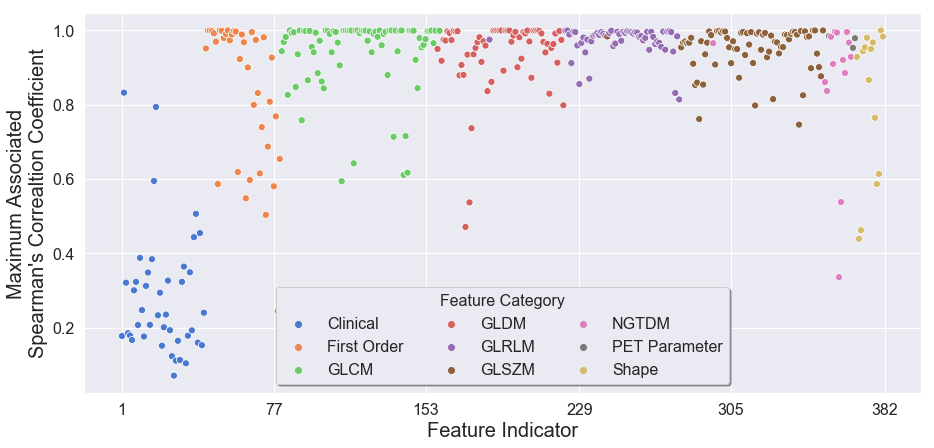

In [41]:
# The maximum Spearman's Correlation Coefficient a feature associates with
# another feature from the Hassan transformed feature matrix. That is, max SCC of features
# after the Hassan transforms.

red_feature_cats = np.array(to_feature_categories(upper_red.columns))
sorted_cats_idx = np.argsort(red_feature_cats)

to_drop = np.where(sorted_cats_idx == np.max(sorted_cats_idx))
sorted_cats_idx = np.delete(sorted_cats_idx, to_drop)
red_feature_cats = np.delete(red_feature_cats, to_drop)

plt.figure(figsize=(15, 7))
sns.scatterplot(
    np.arange(np.size(red_max_feature_corr)), 
    red_max_feature_corr[sorted_cats_idx],
    hue=red_feature_cats[sorted_cats_idx],
    palette=sns.color_palette('muted', len(np.unique(red_feature_cats))),
    s=50
)
plt.legend(
    fontsize=16, title_fontsize=16, title='Feature Category', loc='upper center', 
    bbox_to_anchor=(0.5, 0.3), ncol=3, fancybox=True, shadow=True
)
plt.ylabel("Maximum Associated\nSpearman's Correaltion Coefficient", fontsize=20)
plt.xlabel('Feature Indicator', fontsize=20)
plt.xticks(
    np.linspace(0, np.size(red_max_feature_corr), 6, dtype=int), 
    np.linspace(1, np.size(red_max_feature_corr), 6, dtype=int), 
    fontsize=16
)
plt.yticks(fontsize=16)

plt.savefig(
    path_scc_hassan, 
    bbox_inches='tight',
    dpi=100, 
)

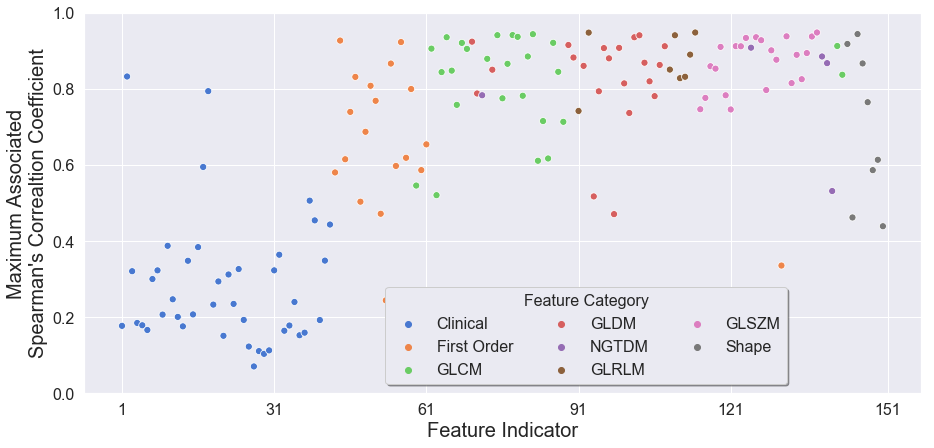

In [42]:
# The maximum Spearman's Correlation Coefficient a feature associates with
# another feature from the Hassan transformed feature matrix including removal of 
# features with maximum SCC > 0.95.
red_dropped_feature_cats = np.array(to_feature_categories(upper_red_dropped.columns))
sorted_cats_idx = np.argsort(red_dropped_feature_cats)

to_drop = np.where(sorted_cats_idx == np.max(sorted_cats_idx))
sorted_cats_idx = np.delete(sorted_cats_idx, to_drop)
red_dropped_feature_cats = np.delete(red_dropped_feature_cats, to_drop)

plt.figure(figsize=(15, 7))
sns.scatterplot(
    np.arange(np.size(red_dropped_max_feature_corr)), 
    red_dropped_max_feature_corr[sorted_cats_idx],
    hue=red_dropped_feature_cats[sorted_cats_idx],
    palette=sns.color_palette('muted', len(np.unique(red_dropped_feature_cats))),
    s=50
)
plt.legend(
    fontsize=16, title_fontsize=16, title='Feature Category', loc='upper center', 
    bbox_to_anchor=(0.6, 0.3), ncol=3, fancybox=True, shadow=True
)
plt.ylabel("Maximum Associated\nSpearman's Correaltion Coefficient", fontsize=20)
plt.xlabel('Feature Indicator', fontsize=20)
plt.xticks(
    np.linspace(0, np.size(red_dropped_max_feature_corr), 6, dtype=int), 
    np.linspace(1, np.size(red_dropped_max_feature_corr), 6, dtype=int), 
    fontsize=16
)
plt.yticks(np.linspace(0.0, 1.0, 6), np.round(np.linspace(0.0, 1.0, 6), 1), fontsize=16)
plt.savefig(
    path_scc_hassan_dropped, 
    bbox_inches='tight',
    dpi=100, 
)

In [43]:
X_red_dropped.to_csv(path_red_dropped)
X_red_dropped.shape

(198, 152)

In [44]:
size_reduced = [
    sum(cat == red_dropped_feature_cats) / len(red_dropped_feature_cats) 
    for cat in np.unique(red_dropped_feature_cats)
]
sum(size_reduced)

1.0

In [45]:
size_orig = [
    sum(cat == red_feature_cats) / len(red_feature_cats) 
    for cat in np.unique(red_feature_cats)
]
sum(size_orig)

1.0

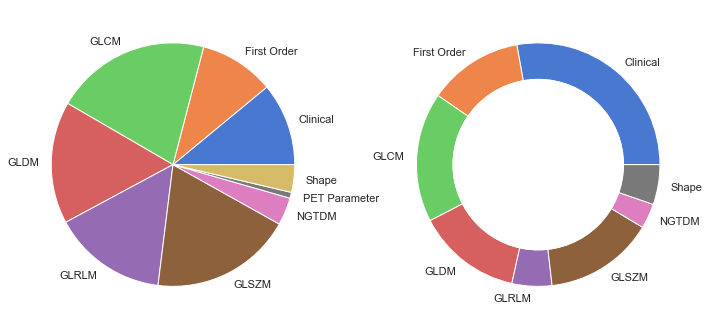

In [46]:
sizes = [size_orig, size_reduced]
labels = [np.unique(red_feature_cats), np.unique(red_dropped_feature_cats)]

fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    axis.pie(
        sizes[num], 
        labels=labels[num], 
        colors=sns.color_palette('muted', len(labels[num]))
    )
    circle = plt.Circle((0, 0), 0.7, color='white')
    p = plt.gcf()
    p.gca().add_artist(circle)

In [47]:
red_corr_matrix.filter(regex='Voxel')

,original_shape_VoxelVolume
Age,0.135613
Years Smoking,0.058843
Naxogin Days,0.056018
Sex_M,0.171859
ICD-10_C02,0.214056
ICD-10_C03,0.120289
ICD-10_C04,0.086441
ICD-10_C05,0.135661
ICD-10_C06,0.122782
ICD-10_C09,0.015707


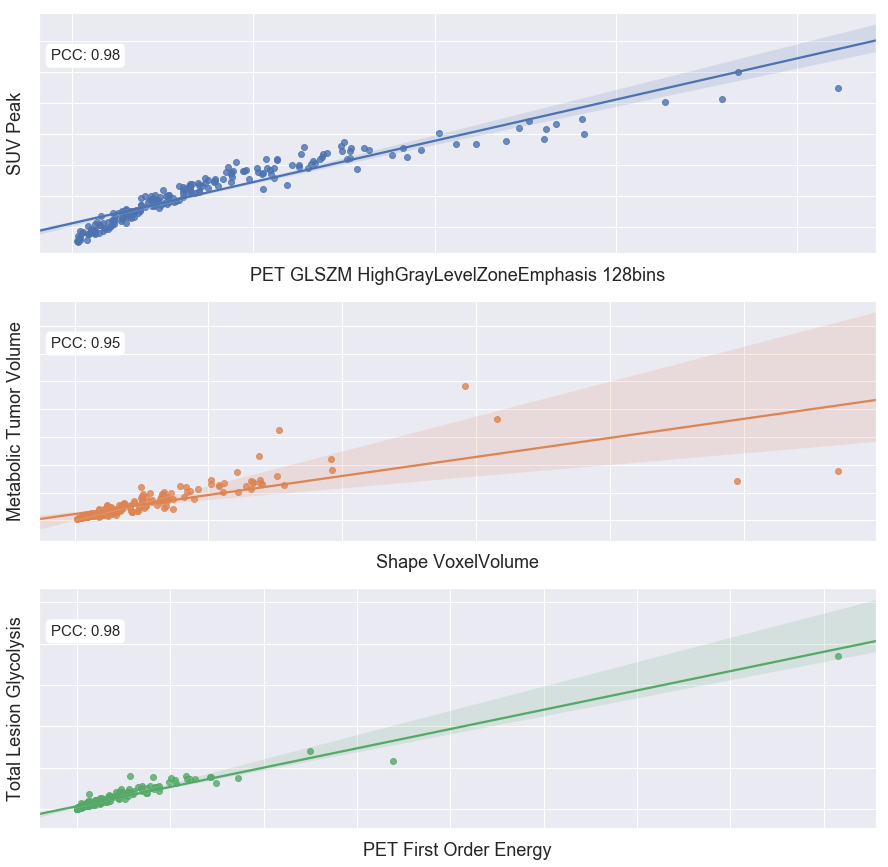

In [48]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 15))

sns.regplot(
    y='PETparam_SUVpeak',
    x='PET_original_glszm_HighGrayLevelZoneEmphasis_128bins',
    data=X_red,
    ax=axes[0]
)
sns.regplot(
    y='PETparam_MTV',
    x='original_shape_VoxelVolume',
    data=X_red,
    ax=axes[1]
)
sns.regplot(
    y='PETparam_TLG',
    x='PET_original_firstorder_Energy',
    data=X_red,
    ax=axes[2]
)
y_labels = ['SUV Peak', 'Metabolic Tumor Volume', 'Total Lesion Glycolysis']
x_labels = ['PET GLSZM HighGrayLevelZoneEmphasis 128bins', 'Shape VoxelVolume', 'PET First Order Energy']
scores = [
    red_corr_matrix.loc['PETparam_SUVpeak', 'PET_original_glszm_HighGrayLevelZoneEmphasis_128bins'],
    red_corr_matrix.loc['PETparam_MTV', 'original_shape_VoxelVolume'],
    red_corr_matrix.loc['PETparam_TLG', 'PET_original_firstorder_Energy']
]
for num, axis in enumerate(axes.ravel()):
    axis.set_xlabel(x_labels[num], fontsize=18)
    axis.set_ylabel(y_labels[num], fontsize=18)
    axis.set_xticklabels([], fontsize=16)
    axis.set_yticklabels([], fontsize=16)
    axis.annotate(
        f"PCC: {np.round(scores[num], 2)}", 
        xy=(12, 190),
        xycoords='axes points',
        size=15, 
        ha='left', 
        va='bottom',
        bbox=dict(boxstyle='round', fc='w')
    )
plt.subplots_adjust(hspace=0.2)
plt.savefig(
    path_pet_params_corr,
    bbox_inches='tight',
    dpi=100, 
)

# Illustration

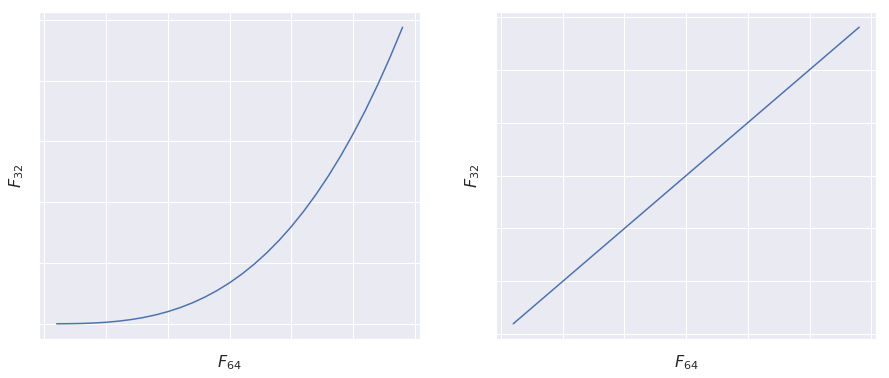

In [59]:
x = np.arange(1, 30)
x3 = np.arange(1, 30) ** 3

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
axes[0].plot(x, x3)
axes[0].set_ylabel(r'$F_{32}$', fontsize=16)
axes[0].set_xlabel(r'$F_{64}$', fontsize=16)

axes[1].plot(x, x3 / x ** 2)
axes[1].set_ylabel(r'$F_{32}$', fontsize=16)
axes[1].set_xlabel(r'$F_{64}$', fontsize=16)

for axis in axes.ravel():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    
plt.savefig(
    'ill_feat_discr_dep.png',
    bbox_inches='tight',
    dpi=100, 
)